## Step 0: Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scipy.stats import beta

## Step 1: Transform and split the data

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [3]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 1.95
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [4]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [5]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [6]:
# look up zero-inflated fits for beta, we're throwing out a small fraction of 0-like videos
prior_a, prior_b, loc, scale = beta.fit([i for i in train_videos.values if i != 0], floc=0, fscale=1)

In [7]:
print(prior_a, prior_b)

0.9492941782464519 16.534909180069906


In [8]:
r = beta.rvs(prior_a, prior_b, size=5000)

Text(0.5, 1.0, 'density plot of eb beta prior')

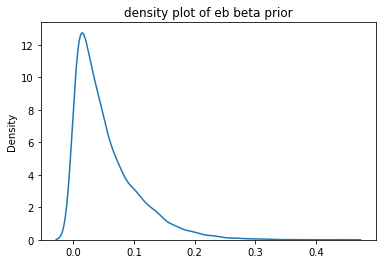

In [9]:
sns.kdeplot(r).set_title('density plot of eb beta prior')

In [10]:
video_df

video_id
103      0.025532
109      0.053154
120      0.102055
122      0.031228
128      0.023388
           ...   
10506    0.080351
10519    0.177098
10552    0.006383
10589    0.059914
10595    0.107988
Name: liked, Length: 3327, dtype: float64

## Step 2: Merge the datasets and select from test set different products

In [11]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [12]:
kuairec_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,liked,like_ratio
0,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,0,0.145996
1,19,183,8033,6100,2020-07-25 09:51:33.664,20200725.0,1.595642e+09,1.316885,0,0.145996
2,21,183,15770,6100,2020-07-08 07:00:20.865,20200708.0,1.594163e+09,2.585246,1,0.145996
3,23,183,20786,6100,2020-07-05 07:50:01.81,20200705.0,1.593907e+09,3.407541,1,0.145996
4,24,183,4737,6100,2020-07-05 03:47:59.561,20200705.0,1.593892e+09,0.776557,0,0.145996


Text(0.5, 1.0, 'histogram of like ratios')

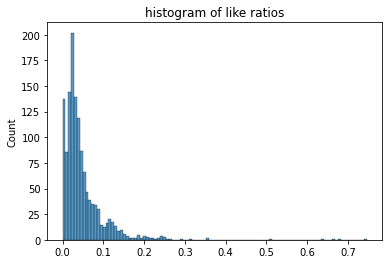

In [13]:
sns.histplot(test_videos.values).set_title('histogram of like ratios')

In [14]:
num_samples = 100

In [15]:
sampled_videos = (list(test_videos.sample(num_samples, random_state=1729).keys()))

In [16]:
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]

In [17]:
video_df[sampled_videos].sort_values()

video_id
9136    0.000000
7566    0.000000
883     0.000000
8696    0.000000
4664    0.000709
          ...   
1205    0.122165
858     0.136782
2311    0.138396
2687    0.155209
7076    0.246634
Name: liked, Length: 100, dtype: float64

In [18]:
videos_of_interest = video_df[sampled_videos].sort_values()
videos_of_interest = list(videos_of_interest.iloc[[-1, -2, num_samples//5, 2*num_samples//5, 3*num_samples//5, 4*num_samples//5]].keys())
videos_of_interest

[7076, 2687, 2678, 627, 1377, 7257]

In [19]:
indices_of_interest = [sampled_videos.index(item) for item in videos_of_interest]

## Step 3: Set up the bandit environment

In [20]:
# set up experiment in a way where we can later interpolate between uninformed prior and eb
uninformed_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2)
eb_priors = np.array([[prior_a]*len(sampled_videos),[prior_b]*len(sampled_videos)]).T
# eb_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2) + np.array([0,1])

In [21]:
def random_argmax(alist):
  maxval = max(alist)
  argmax = [idx for idx, val in enumerate(alist) if val == maxval]
  return np.random.choice(argmax)

def ts_action(actions, num_success, num_failure):
  p_hat = [np.random.beta(num_success[a],num_failure[a]) for a in actions]
  a = random_argmax(p_hat)
  return a

def greedy_action(actions, num_success, num_failure):
  p_hat = [(num_success[a] + 1) / (num_success[a] + num_failure[a] + 2) for a in actions]
  a = random_argmax(p_hat)
  return a

def epsilon_greedy_action(actions, num_success, num_failure):
  if np.random.binomial(1, 0.05):
    a = np.random.choice(actions)
  else:
    a = greedy_action(actions, num_success, num_failure)
  return a

def sample_chosen_df(videos, chosen_df, action_index):
    vid = videos[action_index]
    seen_like = chosen_df[chosen_df['video_id']==vid].sample(1).iloc[0]['liked']
    return seen_like

#### Default multi-armed bandit algorithm

In [22]:
def run_multiarmed_bandit(chosen_df, 
                          videos, 
                          priors, 
                          sampling_action, 
                          timesteps, 
                          num_sims):

    agg_priors_over_time = []
    rewards_over_time = []
    plays = []
    
    for n in range(num_sims):
        if (n+1) % 10 == 0:
            print(f'sim {n+1}/{num_sims}')
            
        instance_priors_over_time = [priors]
        instance_rewards_over_time = [np.zeros(len(videos))]
        instance_plays = np.zeros(len(videos))
        
        for t in range(timesteps):
            newest_prior = instance_priors_over_time[-1].copy()
            newest_rewards = instance_rewards_over_time[-1].copy()
            successes, failures = newest_prior.T[0,:], newest_prior.T[1,:]
            actions = range(len(videos))
            
            a = sampling_action(actions, successes, failures)
            
            instance_plays[a] += 1
            
            like = sample_chosen_df(videos, chosen_df, a)
            
            # update prior
            newest_prior[a,0] += like
            newest_prior[a,1] += 1 - like
            instance_priors_over_time.append(newest_prior)
            
            newest_rewards[a] += like
            instance_rewards_over_time.append(newest_rewards)
            
        instance_priors_over_time = np.stack(instance_priors_over_time)
        instance_rewards_over_time = np.stack(instance_rewards_over_time)
        
        agg_priors_over_time.append(instance_priors_over_time)
        rewards_over_time.append(instance_rewards_over_time)
        plays.append(instance_plays)
        
    agg_priors_over_time = np.stack(agg_priors_over_time)
    rewards_over_time = np.stack(rewards_over_time)
    plays = np.stack(plays)
            
    return agg_priors_over_time, rewards_over_time, plays
            
        

#### Multi-armed bandit with replenishment

In [23]:
class ProductHelper:
    """Class for helping keep track of all the products we have."""
    
    def __init__(self, universe, starting_market, mkt_ids, priors):
        self.universe = universe
        self.mkt_ids = mkt_ids
        self.priors = priors
        self.market = [np.array([copy.deepcopy(self.priors)[k]]) for k in starting_market]
        
    def pull_arm(self, action, like):
        arr = self.market[action]
        latest_action = copy.deepcopy(arr[-1])
        latest_action += np.array([like, 1-like])
        self.market[action] = np.append(arr, [latest_action], axis=0)
        
    def replace_item(self, old_id, new_id):
        old_idx = self.mkt_ids.index(old_id)
        self.universe[old_id].append(copy.deepcopy(self.market[old_idx]))
        self.mkt_ids[old_idx] = new_id
        self.market[old_idx] = np.array([copy.deepcopy(self.priors[new_id])])

In [24]:
def run_multiarmed_bandit_replenishment(chosen_df,
                                        videos,
                                        priors,
                                        sampling_action,
                                        timesteps,
                                        rho,
                                        mkt_size,
                                        num_users=1):
    product_data = dict(zip(videos, [[] for _ in range(len(videos))]))
    priors_dict = dict(zip(videos, [priors.copy()[i,:] for i in range(priors.shape[0])]))
            
    curr_vids = np.array(list(np.random.choice(videos, mkt_size)))
    curr_vids_indices = np.array([videos.index(v) for v in curr_vids])
    remaining_vids = set(videos).difference(set(curr_vids))
    curr_chosen_df = chosen_df[chosen_df['video_id'].isin(curr_vids)]

    helper = ProductHelper(product_data, curr_vids, list(curr_vids), priors_dict)

    for t in range(timesteps):
        if (t+1) % (timesteps//10) == 0:
            print(f'{t+1}/{timesteps}')
            
        latest_sims = np.array([item[-1] for item in helper.market])
        successes, failures = latest_sims[:,0], latest_sims[:,1]
        actions = range(mkt_size)
        for m in range(num_users):
            a = sampling_action(actions, successes, failures)
            like = sample_chosen_df(videos, chosen_df, curr_vids_indices[a])

            # update prior
            helper.pull_arm(a, like)

        # replenish the indices
        flips = np.random.binomial(1, rho, curr_vids_indices.shape[0])
        draws = np.random.choice(list(remaining_vids), mkt_size)

        new_draws_indices = np.array([videos.index(v) for v in draws])
        replenishments = flips * draws
        replaced = flips * curr_vids

        remaining_vids = remaining_vids.union(set(replaced[replaced != 0].flatten())
                                           ).difference(set(replenishments[replenishments != 0].flatten()))
        curr_vids = (1-flips) * curr_vids + flips * draws
        curr_vids_indices = (1-flips) * curr_vids_indices + flips * new_draws_indices
        curr_chosen_df = chosen_df[chosen_df['video_id'].isin(curr_vids)]

        swapped_pairs = zip(list(replaced[replaced != 0].flatten()), list(replenishments[replenishments != 0].flatten()))
        for old,new in swapped_pairs:
            helper.replace_item(old, new)
            
    for prod in helper.mkt_ids:
        mkt_idx = helper.mkt_ids.index(prod)
        helper.universe[prod].append(helper.market[mkt_idx])
            
    return helper.universe

## Step 4: Run the simulations and save data

In [25]:
timesteps = 500000

In [26]:
uninformed_data = run_multiarmed_bandit_replenishment(kuairec_chosen,
                                                      sampled_videos,
                                                      uninformed_priors,
                                                      ts_action,
                                                      timesteps=timesteps,
                                                      rho=0.01,
                                                      mkt_size=10)

50000/500000
100000/500000
150000/500000
200000/500000
250000/500000
300000/500000
350000/500000
400000/500000
450000/500000
500000/500000


In [27]:
eb_data = run_multiarmed_bandit_replenishment(kuairec_chosen,
                                              sampled_videos,
                                              eb_priors,
                                              ts_action,
                                              timesteps=timesteps,
                                              rho=0.01,
                                              mkt_size=10)

50000/500000
100000/500000
150000/500000
200000/500000
250000/500000
300000/500000
350000/500000
400000/500000
450000/500000
500000/500000


## Step 5: Plot and analyze the data from replenishment model

In [40]:
times_of_interest = [0,5,10,20,50,100]

In [41]:
def mean_centered_credible_int(arr):
    a,b = arr[0], arr[1]
    mean = a/(a+b)
    mean_cdf = beta.cdf(mean,a,b)
    if mean_cdf > 0.525: #we'll have to have a longer left tail
        left_remainder = 0.95 - (1 - mean_cdf)
        return (beta.ppf(left_remainder,a,b),1)
    elif mean_cdf < 0.475: #we'll have to have a longer right tail
        right_remainder = 0.95 - mean_cdf
        return (0, beta.ppf(right_remainder,a,b))
    else:
        return (beta.ppf(mean_cdf-0.475,a,b), beta.ppf(mean_cdf+0.475,a,b))

In [42]:
uninf_dict = dict()
eb_dict = dict()
uninf_conf_intervals = dict()
eb_conf_intervals = dict()

for prod in videos_of_interest:
    for time in times_of_interest:
        value = [uninformed_data[prod][i][time] for i in range(len(uninformed_data[prod])) 
                                                                   if time < uninformed_data[prod][i].shape[0]]
        value = np.array(value)
        uninf_dict[(prod, time)] = value
        if value.size > 0:
            conf_intervals = np.apply_along_axis(mean_centered_credible_int, 1, value)
            uninf_conf_intervals[(prod, time)] = np.mean(conf_intervals,axis=0)
        else:
            uninf_conf_intervals[(prod,time)] = None
            
        value = [eb_data[prod][i][time] for i in range(len(eb_data[prod])) 
                                        if time < eb_data[prod][i].shape[0]]
        value = np.array(value)
        eb_dict[(prod, time)] = np.array(value)
        if value.size > 0:
            conf_intervals = np.apply_along_axis(mean_centered_credible_int, 1, value)
            eb_conf_intervals[(prod, time)] = np.mean(conf_intervals,axis=0)
        else:
            eb_conf_intervals[(prod,time)] = None

In [43]:
def plot_est_quality(data, true_quals, conf_ints, products, time, ax=None, title=None):
    dep, errbar, prods_to_plot, tq_to_plot = [], [], [], []

    i=0
    for prod in products:
        if type(conf_ints[(prod,time)])==np.ndarray:
            mean = data[(prod, time)][:,0]/(data[(prod, time)][:,0]+data[(prod, time)][:,1])
            mean = np.mean(mean)
            dep.append(mean)
            errbar.append([mean-conf_ints[(prod,time)][0], -mean+conf_ints[(prod,time)][1]])
            prods_to_plot.append(str(prod))
            tq_to_plot.append(true_quals[i])
        i += 1
        
    if ax:
        plt.sca(ax)
    
    plt.ylim(0, 1)
    plt.scatter(x=prods_to_plot, y=np.array(dep), label='est quality')
    plt.scatter(x=prods_to_plot, y=tq_to_plot, label='true quality')
    plt.errorbar(x=prods_to_plot, y=np.array(dep), yerr=np.array(errbar).T, fmt='o')      
    plt.legend()
    
    if title:
        plt.title(title)


In [44]:
true_quality = list(video_df[videos_of_interest].values.round(4))

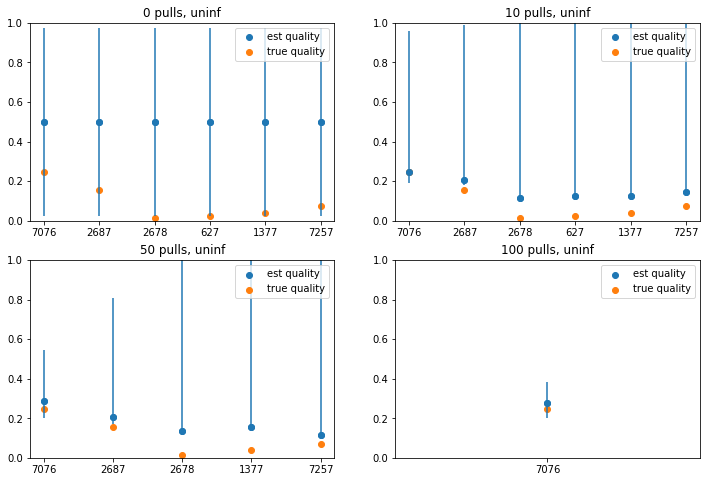

In [45]:
f, axes = plt.subplots(2,2)
f.set_size_inches(12,8)
plot_est_quality(uninf_dict, true_quality, uninf_conf_intervals, videos_of_interest, 0, ax=axes[0,0],title='0 pulls, uninf')
plot_est_quality(uninf_dict, true_quality, uninf_conf_intervals, videos_of_interest, 10, ax=axes[0,1],title='10 pulls, uninf')
plot_est_quality(uninf_dict, true_quality, uninf_conf_intervals, videos_of_interest, 50, ax=axes[1,0],title='50 pulls, uninf')
plot_est_quality(uninf_dict, true_quality, uninf_conf_intervals, videos_of_interest, 100, ax=axes[1,1],title='100 pulls, uninf')
plt.show()

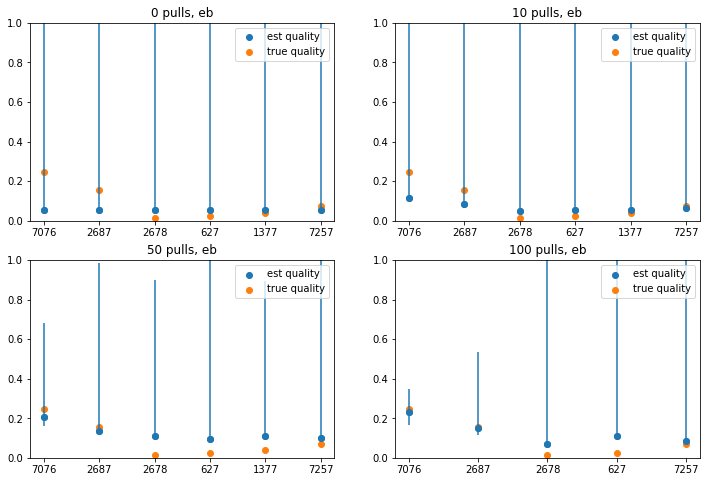

In [46]:
f, axes = plt.subplots(2,2)
f.set_size_inches(12,8)
plot_est_quality(eb_dict, true_quality, eb_conf_intervals, videos_of_interest, 0, ax=axes[0,0],title='0 pulls, eb')
plot_est_quality(eb_dict, true_quality, eb_conf_intervals, videos_of_interest, 10, ax=axes[0,1],title='10 pulls, eb')
plot_est_quality(eb_dict, true_quality, eb_conf_intervals, videos_of_interest, 50, ax=axes[1,0],title='50 pulls, eb')
plot_est_quality(eb_dict, true_quality, eb_conf_intervals, videos_of_interest, 100, ax=axes[1,1],title='100 pulls, eb')
plt.show()

### 5.1 Plot the histogram of plays for each product

In [51]:
uninf_data_counts = [[arr.shape[0] for arr in uninformed_data[key]] for key in videos_of_interest]
eb_data_counts = [[arr.shape[0] for arr in eb_data[key]] for key in videos_of_interest]

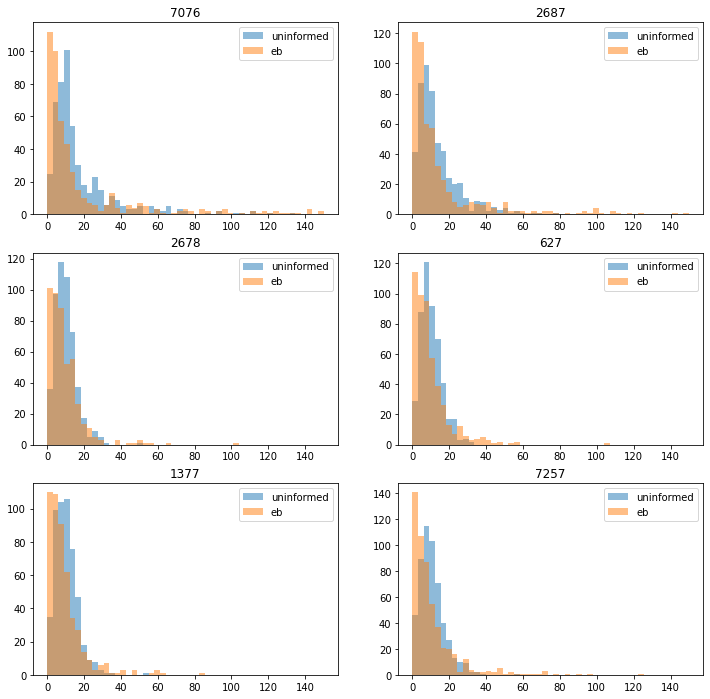

In [62]:
f, axes = plt.subplots(3,2)
f.set_size_inches(12,12)
ax_path = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1]]
for i in range(len(videos_of_interest)):
    plt.sca(ax_path[i])
    bins = np.linspace(0, 150, 50)
    plt.hist(uninf_data_counts[i],bins,alpha=0.5,label='uninformed')
    plt.hist(eb_data_counts[i],bins,alpha=0.5,label='eb')
    plt.title(videos_of_interest[i])
    plt.legend()
    
plt.show()